# This notebook reassesses the Big Plot with mean uncertainties calculated for stellar mass.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy.polynomial.polynomial import polyfit
import pandas as pd
from matplotlib_venn import venn3, venn3_circles
import matplotlib.lines as lines
from astropy import constants as const
from astropy.io import fits
import astropy.coordinates as coord
import astropy.units as u
from astropy.table import Table
# import ephem
from astropy.cosmology import FlatLambdaCDM

In [2]:
#---------------------------------------------------------
#Constants, taken from mass_SFR.py done by former students
#---------------------------------------------------------
Mag_sun_w1 = 3.254
Mag_sun_error_w1 = np.sqrt(0.008**2+0.02**2) #extra 0!!
Mag_sun_kt = 3.302
Mag_sun_error_kt = np.sqrt(0.008**2+0.02**2)
lum_sun = 3.828e26 #in W from NASA fact sheet
c = const.c.to('km/s').value #c in km/s
nu_3 = (c*1000)/(11.5608e-6) #in s^-1 from Table 1 in Jarrett et al. (2011) (link: http://iopscience.iop.org/article/10.1088/0004-637X/735/2/112/pdf)
zp_3 = 31.674 #in Jy Table 1 this WISE guide: http://wise2.ipac.caltech.edu/docs/release/allsky/expsup/sec4_4h.html#example
a_3 = [1.13, 10.24] #Cluver14
a_4 = [0.82, 7.3] #Cluver14
h0 = 73.8 #h0 in km/(Mpc*s) Riess2011
h0_error = 2.4 # km/(Mpc*s)
parsec = 3.08567758e16 #m
jansky = 1e-26 #W/m^2/Hz
cosmo = FlatLambdaCDM(h0, Om0=0.262) # Shawn: to match cosmology used by Becky

In [3]:
spec = pd.read_csv('/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Files/spec_latest.csv')
mac = pd.read_csv('/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Files/mac_latest.csv')
zoo = pd.read_csv('/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Files/zoo_latest.csv')
#decals = pd.read_csv('/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Files/decals_gama.csv')
#s4tm = pd.read_csv('/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Files/s4tm_gama.csv')
#slacs = pd.read_csv('/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Files/slacs_gama.csv')

In [4]:
# load in MagPhys fits file
hdul = fits.open('/home/shawn/Desktop/gravitational_lensing_research/FITS_Files/MagPhys.fits')  # open a FITS file
hdul.verify('fix')
magphys = hdul[1].data  # assume the first extension is a table
print(magphys.columns)

ColDefs(
    name = 'CATAID'; format = 'J'; null = -2147483648
    name = 'Z'; format = 'E'
    name = 'f_mu_SFH_best_fit'; format = 'E'
    name = 'f_mu_SFH_percentile2_5'; format = 'E'
    name = 'f_mu_SFH_percentile16'; format = 'E'
    name = 'f_mu_SFH_percentile50'; format = 'E'
    name = 'f_mu_SFH_percentile84'; format = 'E'
    name = 'f_mu_SFH_percentile97_5'; format = 'E'
    name = 'f_mu_IR_best_fit'; format = 'E'
    name = 'f_mu_IR_percentile2_5'; format = 'E'
    name = 'f_mu_IR_percentile16'; format = 'E'
    name = 'f_mu_IR_percentile50'; format = 'E'
    name = 'f_mu_IR_percentile84'; format = 'E'
    name = 'f_mu_IR_percentile97_5'; format = 'E'
    name = 'mu_parameter_best_fit'; format = 'E'
    name = 'mu_parameter_percentile2_5'; format = 'E'
    name = 'mu_parameter_percentile16'; format = 'E'
    name = 'mu_parameter_percentile50'; format = 'E'
    name = 'mu_parameter_percentile84'; format = 'E'
    name = 'mu_parameter_percentile97_5'; format = 'E'
    name = 

In [8]:
# concatenate candidate catalogs to one dataframe

candidates = pd.concat([spec, mac, zoo])

# add columns for percentile 84 and 16
GAMA_ID = magphys.CATAID
mass_84 = magphys.mass_stellar_percentile84
mass_16 = magphys.mass_stellar_percentile16

magphys_uncertainty = list(zip(GAMA_ID, mass_84, mass_16))
uncertainty = pd.DataFrame(magphys_uncertainty, columns = ['GAMA_ID','mass_84','mass_16'])
candidates_uncertainty = pd.merge(candidates, uncertainty, how = 'inner', on = 'GAMA_ID')

candidates_uncertainty

/home/shawn/miniconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


,DEC,Dz,GAMA_ID,ID,LENS_SCORE,RA,SCORE,STELLAR_MASS,TOTAL_MASS,Unnamed: 0,...,max_stellar_mass_salpeter,max_total_mass,spec_type,theta_e,theta_e2,z1,z2,z_lens,mass_84,mass_16
0,-0.66673,0.158,198082.0,NaN,NaN,138.28150,NaN,3.025000e+10,NaN,0,...,1.142496e+11,1.655791e+11,PG+ELG,0.514681,0.556251,0.163,0.321,0.163,10.600,10.400
1,-0.35203,0.167,204140.0,NaN,NaN,136.63883,NaN,8.578000e+10,NaN,2,...,2.615761e+11,3.790958e+11,PG+ELG,0.572792,0.346664,0.282,0.449,0.282,11.010,10.830
2,0.16360,0.475,209222.0,NaN,NaN,132.36771,NaN,1.425000e+10,NaN,3,...,5.605996e+10,8.124632e+10,PG+ELG,0.504294,0.897134,0.128,0.603,0.128,10.430,10.170
3,0.11972,0.295,209295.0,NaN,NaN,132.61013,NaN,8.456000e+10,NaN,4,...,2.225589e+11,3.225492e+11,PG+ELG,0.616542,0.417813,0.313,0.608,0.313,11.090,10.900
4,1.22984,0.240,301818.0,NaN,NaN,135.32929,NaN,1.215000e+11,NaN,6,...,-1.729154e+11,-2.506021e+11,PG+ELG,NaN,0.677986,0.487,0.247,0.247,11.210,11.020
5,1.33144,0.189,302719.0,NaN,NaN,138.94058,NaN,1.474000e+11,NaN,7,...,-4.373140e+11,-6.337884e+11,PG+ELG,NaN,0.245262,0.593,0.404,0.404,11.200,11.070
6,1.02071,0.622,371208.0,NaN,NaN,130.50925,NaN,4.812000e+09,NaN,8,...,2.985359e+10,4.326608e+10,PG+ELG,0.401576,1.110453,0.077,0.699,0.077,9.742,9.487
7,2.13736,0.148,383284.0,NaN,NaN,140.65750,NaN,4.275000e+10,NaN,10,...,1.546626e+11,2.241486e+11,PG+ELG,0.525870,0.459768,0.194,0.342,0.194,10.670,10.500
8,2.51429,0.132,388201.0,NaN,NaN,138.99892,NaN,3.647000e+10,NaN,11,...,1.305067e+11,1.891402e+11,PG+ELG,0.528755,0.520645,0.167,0.299,0.167,10.700,10.540
9,2.29438,0.349,417645.0,NaN,NaN,132.51888,NaN,8.476000e+09,NaN,12,...,4.879032e+10,7.071060e+10,PG+ELG,0.416900,0.817389,0.108,0.457,0.108,10.090,9.877


In [11]:
mean_error = np.mean(0.5 * (candidates_uncertainty.mass_84 - candidates_uncertainty.mass_16))
mean_error

0.08989475484479938

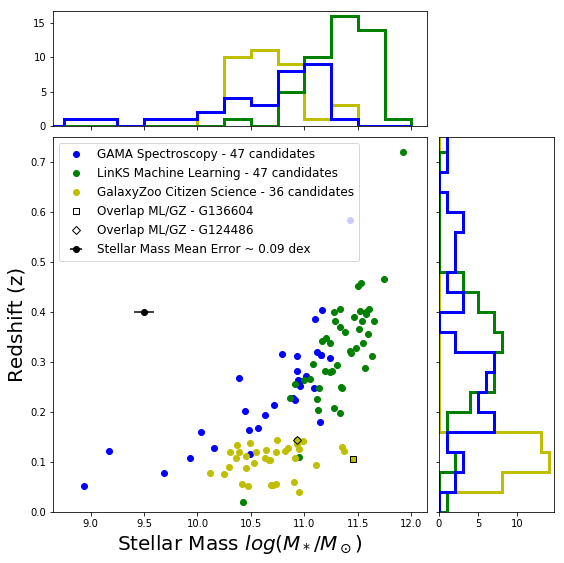

In [32]:
# Three-panel plot
from matplotlib.ticker import NullFormatter
nullfmt   = NullFormatter()         # no labels
# definitions for the axes
left, width = 0.1, 0.65
lower, height = 0.1, 0.65
lower_h = left_h = left+width+0.02
    
rect_scatter = [left, lower, width, height]
rect_histx = [left, lower_h, width, 0.2]
rect_histy = [left_h, lower, 0.2, height]
    
    # start with a rectangular Figure
plt.figure(1, figsize=(8,8))
    
axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)
    
    # no labels
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)

# the scatter plots
axScatter.set_xlim((min(np.log10(zoo.STELLAR_MASS))-0.5, max(np.log10(mac.STELLAR_MASS))+0.5))
axScatter.set_ylim((min(mac.Z)-0.05, max(mac.Z)+0.05))
axScatter.plot(np.log10(spec.STELLAR_MASS), spec.z_lens, 'bo',label='GAMA Spectroscopy - 47 candidates')
#axScatter.plot(np.log10(3.6425e+10), 0.1968, 'b*',label='Median GAMA', ms = 20, fillstyle = 'none')
#axScatter.plot(np.log10(spec.max_stellar_mass_salpeter), spec.z1, 'b^',label='GAMA Spec 2-arcsec Aperture Max Mass', fillstyle='none')
axScatter.plot(np.log10(mac.STELLAR_MASS), mac.Z, 'go',label='LinKS Machine Learning - 47 candidates')
#axScatter.plot(np.log10(2.00e+11),0.19, 'g*',label='Median SLACS', ms = 20, fillstyle = 'none')
axScatter.plot(np.log10(zoo.STELLAR_MASS), zoo.Z, 'yo',label='GalaxyZoo Citizen Science - 36 candidates')
#axScatter.plot(np.log10(9.662e+09),0.1076, 'y*',label='Median GalaxyZoo Population', ms=20, fillstyle = 'none')
#axScatter.plot(np.log10(decals.STELLAR_MASS), decals.Z, 'rs',label='DECALS - 2 candidates', fillstyle = 'none')
#axScatter.plot(np.log10(slacs.STELLAR_MASS), slacs.Z, 'cs',label='SLACS - 2 candidates', fillstyle = 'none')
#axScatter.plot(np.log10(s4tm.STELLAR_MASS), s4tm.Z, 'ms',label='S4TM - 1 candidate', fillstyle = 'none')

# plot two overlaps
G136604 = mac[mac.GAMA_ID == 136604]
G124486 = mac[mac.GAMA_ID == 124486]
axScatter.plot(np.log10(G136604.STELLAR_MASS), G136604.Z, 'ks', label='Overlap ML/GZ - G136604', fillstyle = 'none')
axScatter.plot(np.log10(G124486.STELLAR_MASS), G124486.Z, 'kD', label='Overlap ML/GZ - G124486', fillstyle = 'none')

#axScatter.plot(9.5,0.4, 'ko')
axScatter.errorbar(9.5, 0.4,  
                   xerr= mean_error,
                  fmt = 'o',
                   color = 'black',
                   solid_capstyle = 'round',
                  label = 'Stellar Mass Mean Error ~ 0.09 dex')

axScatter.legend(loc='upper left', numpoints=1, fontsize = 12)
    
    
# now determine nice limits by hand:
binwidth = 0.5
bins=20
#xbins = np.arange(min(zoo_hard_cut.STELLAR_MASS),max(zoo_hard_cut.STELLAR_MASS), (max(zoo_hard_cut.STELLAR_MASS)-min(zoo_hard_cut.STELLAR_MASS))/bins)
#ybins = np.arange(min(zoo_hard_cut.Z),max(zoo_hard_cut.Z), (max(zoo_hard_cut.Z)-min(zoo_hard_cut.Z))/bins)

#axScatter.set_xlim((min(zoo.STELLAR_MASS)-0.5, max(zoo.STELLAR_MASS)+0.5))
#axScatter.set_ylim((min(zoo.Z)-0.05, max(zoo.Z)+0.05))
axScatter.axis([8.65,12.15,0.,0.75], prop={'size':25})

axScatter.set_xlabel(r'Stellar Mass $log(M_*/M_\odot)$', fontsize=20)
axScatter.set_ylabel(r'Redshift (z)', fontsize=20)
    
#xbins = np.arange(8.5, 12.5, xbinwidth)
#ybins = np.arange(0., 0.6, ybinwidth)
    
axHisty.hist(zoo.Z, orientation='horizontal', range=[0,0.8], bins=bins,color='y', histtype = 'step', linewidth=3)
axHisty.hist(mac.Z, orientation='horizontal', range=[0,0.8], bins=bins,color='g', histtype = 'step', linewidth=3)
axHisty.hist(spec.z1, orientation='horizontal', range=[0,0.8],  bins=bins,color='b',  histtype = 'step', linewidth=3)
    
axHistx.hist(np.log10(zoo.STELLAR_MASS), range=[7,12], bins=bins,color='y', histtype = 'step', linewidth=3)
axHistx.hist(np.log10(mac.STELLAR_MASS), range=[7,12], bins=bins,color='g', histtype = 'step', linewidth=3)
axHistx.hist(np.log10(spec.STELLAR_MASS), range=[7,12], bins=bins,color='b', histtype = 'step', linewidth=3)
    
axHistx.set_xlim( axScatter.get_xlim() )
axHisty.set_ylim( axScatter.get_ylim() )

#plt.savefig('/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Visuals/121519_all_methods_medians_maxmasses_additional_surveys.pdf')
#plt.savefig('/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Visuals/050420_bp_overlaps.png')
plt.savefig('/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Visuals/Final_PDFs_for_Paper/bp_overlaps.pdf')
#plt.savefig('/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Visuals/050420_bp_overlaps.png')

## Check for overlaps!

In [23]:
# 2 overlaps!
pd.merge(zoo, mac, on = 'GAMA_ID')

,Unnamed: 0_x,GAMA_ID,RA_x,DEC_x,LENS_SCORE,STELLAR_MASS_x,Z_x,TOTAL_MASS,theta_e_x,Unnamed: 0_y,ID,RA_y,DEC_y,SCORE,STELLAR_MASS_y,Z_y,theta_e_y
0,5772,124486,179.72998,-2.51919,0.426190,8.541000e+10,0.1435,2.190000e+11,1.235660,24,2553.0,179.73003,-2.51895,28.0,8.541000e+10,0.1435,0.740108
1,11076,136604,175.87349,-1.74167,0.316451,2.866000e+11,0.1060,7.348718e+11,2.633636,32,1642.0,175.87355,-1.74164,58.0,2.866000e+11,0.1060,1.811693


In [24]:
pd.merge(mac, spec, on = 'GAMA_ID')

,Unnamed: 0_x,GAMA_ID,ID,RA_x,DEC_x,SCORE,STELLAR_MASS_x,Z_x,theta_e_x,Unnamed: 0_y,...,z2,spec_type,STELLAR_MASS_y,max_total_mass,theta_e_y,Z_y,max_stellar_mass_salpeter,max_stellar_mass_chabrier,Dz,theta_e2


In [25]:
pd.merge(zoo, spec, on = 'GAMA_ID')

,Unnamed: 0_x,GAMA_ID,RA_x,DEC_x,LENS_SCORE,STELLAR_MASS_x,Z_x,TOTAL_MASS,theta_e_x,Unnamed: 0_y,...,z2,spec_type,STELLAR_MASS_y,max_total_mass,theta_e_y,Z_y,max_stellar_mass_salpeter,max_stellar_mass_chabrier,Dz,theta_e2


,Unnamed: 0,GAMA_ID,ID,RA,DEC,SCORE,STELLAR_MASS,Z,theta_e
0,0,3899011.0,2251.0,131.33397,-0.91563,64.0,3.294000e+11,0.4027,2.276871
1,1,376338.0,2660.0,132.98734,1.50468,30.0,3.034000e+11,0.3272,1.364552
2,2,323152.0,2967.0,130.54643,1.64325,30.0,8.277000e+11,0.7216,2.743990
3,3,663364.0,2669.0,140.35284,-0.97414,28.0,2.688000e+11,0.3221,2.321027
4,4,3629152.0,1933.0,135.88864,-0.97487,26.0,2.129000e+11,0.4059,1.320949
5,5,3575500.0,1906.0,129.23265,-1.57512,26.0,3.209000e+11,0.3652,1.185241
6,6,197972.0,2007.0,137.85838,-0.75280,24.0,3.551000e+11,0.3373,1.367670
7,7,3883690.0,2756.0,134.57492,-1.55142,22.0,1.362000e+11,0.2481,0.767594
8,8,3911769.0,1704.0,138.66089,-1.11639,20.0,1.740000e+11,0.2794,2.407686
9,9,371400.0,2275.0,131.20438,1.00064,18.0,2.021000e+11,0.2948,1.751501
